# 영화리뷰 텍스트 감성분석하기

### 라이브러리 버전을 확인해 봅니다

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


### 1) 데이터 준비와 확인

In [2]:
import pandas as pd
import tensorflow as tf
import os

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
load_data(train_data, test_data, num_words=10000)
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer 

token = Tokenizer()
token.fit_on_texts(word_to_index) # 문장에 토큰화 적용
# token.word_counts # 단어별 빈도수 확인 (결과창 길어서 생략)

# 인덱스 길이, 각 단어 인덱스 값 확인
print(len(token.word_index))
print(token.word_index) # 2회 나온 글쎄요 1번 인덱스, 나머지는 순서대로 

9770
{'♥': 1, "'": 2, 'ost': 3, 'good': 4, 'best': 5, 'no': 6, 'b': 7, 'cg': 8, 'tv': 9, 'sf': 10, 'd': 11, '♡': 12, 'c': 13, 'x': 14, 'm': 15, 'dvd': 16, 'the': 17, 'a': 18, 'i': 19, 'you': 20, 'ebs': 21, 't': 22, 's': 23, 'mbc': 24, 'o': 25, 'cgv': 26, 'pd': 27, 'it': 28, 'ocn': 29, 'kbs': 30, 'f': 31, 'k': 32, 'very': 33, 'mc': 34, 'but': 35, 'av': 36, 'sbs': 37, 'so': 38, 'this': 39, 'xx': 40, 'bgm': 41, 'g': 42, 'z': 43, 'sm': 44, 'top': 45, 'p': 46, 'v': 47, 'out': 48, 'imdb': 49, '영화': 50, '다': 51, '고': 52, '하': 53, '을': 54, '보': 55, '게': 56, '지': 57, '있': 58, '없': 59, '좋': 60, '나': 61, '었': 62, '만': 63, '는데': 64, '너무': 65, '봤': 66, '적': 67, '안': 68, '정말': 69, '로': 70, '음': 71, '것': 72, '아': 73, '네요': 74, '재밌': 75, '어': 76, '같': 77, '점': 78, '지만': 79, '진짜': 80, '했': 81, '에서': 82, '기': 83, '네': 84, '않': 85, '거': 86, '았': 87, '수': 88, '되': 89, '면': 90, 'ㅋㅋ': 91, '말': 92, '연기': 93, '인': 94, '주': 95, '내': 96, '최고': 97, '평점': 98, '이런': 99, '던': 100, '어요': 101, '할': 102, '왜': 103, '겠'

In [8]:
from numpy import array

x = token.texts_to_sequences(word_to_index)
print('리뷰 텍스트, 토큰화 결과: \n', x)
classes = array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

리뷰 텍스트, 토큰화 결과: 
 [[], [], [50], [51], [52], [53], [54], [55], [], [56], [], [], [57], [58], [59], [], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [], [110], [111], [112], [113], [114], [115], [116], [117], [118], [119], [120], [121], [122], [123], [124], [125], [126], [127], [128], [129], [130], [131], [132], [133], [134], [135], [136], [137], [138], [139], [140], [141], [142], [143], [144], [145], [146], [147], [148], [149], [150], [151], [152], [153], [154], [155], [156], [157], [158], [159], [160], [161], [162], [163], [164], [165], [166], [167], [168], [169], [170], [171], [172], [173], [174], [175], [176], [177], [178], [179], [180], [181], [182], [183], [184], [185], [186], [187], [188], [2], [189], [190], [191], 

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences # 케라스 전처리 도구 for 패딩

padded_x = pad_sequences(x,116)
print('패딩결과: \n', padded_x)

패딩결과: 
 [[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0   50]
 ...
 [   0    0    0 ...    0    0 9768]
 [   0    0    0 ...    0    0 9769]
 [   0    0    0 ...    0    0 9770]]


In [10]:
word_to_index

{'': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시간': 95,
 '지루': 96,
 '중': 97,
 '재미있': 98,
 '년': 

In [11]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=0,
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=0,
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [12]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [13]:
from tensorflow.keras.models import Sequential # 레이어(층) 연결
from tensorflow.keras.layers import Dense,Flatten,Embedding # 레이어 설정, 1차원화, word2vect

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [14]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


In [15]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [19]:
imdb = tf.keras.datasets.imdb

# IMDb 데이터셋 다운로드 
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 25000, 테스트 개수: 25000


In [21]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


In [22]:
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


In [23]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
4
the


In [24]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

In [25]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [27]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 2s 4ms/step - loss: 0.6926 - accuracy: 0.5103 - val_loss: 0.6913 - val_accuracy: 0.5287
Epoch 2/20
266/266 [==============================] - 1s 3ms/step - loss: 0.6916 - accuracy: 0.5214 - val_loss: 0.6903 - val_accuracy: 0.5390
Epoch 3/20
266/266 [==============================] - 1s 3ms/step - loss: 0.6913 - accuracy: 0.5245 - val_loss: 0.6899 - val_accuracy: 0.5413
Epoch 4/20
266/266 [==============================] - 1s 3ms/step - loss: 0.6913 - accuracy: 0.5245 - val_loss: 0.6900 - val_accuracy: 0.5405
Epoch 5/20
266/266 [==============================] - 1s 3ms/step - loss: 0.6912 - accuracy: 0.5249 - val_loss: 0.6900 - val_accuracy: 0.5405
Epoch 6/20
266/266 [==============================] - 1s 3ms/step - loss: 0.6912 - accuracy: 0.5247 - val_loss: 0.6897 - val_accuracy: 0.5405
Epoch 7/20
266/266 [==============================] - 1s 3ms/step - loss: 0.6912 - accuracy: 0.5245 - val_loss: 0.6897 - val_accuracy: 0.5405
Epoch 

In [30]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


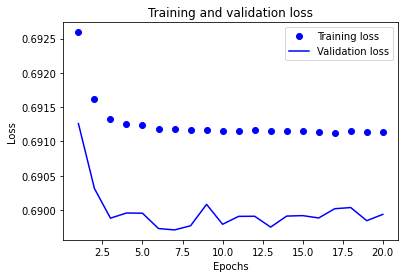

In [31]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [32]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10, 4)


In [33]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [34]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

KeyError: "Key 'computer' not present"

# 회고
#### 어려웠던 점 : 모델을 내가 직접 만들어야 해서 굉장히 난감했다.
#### 알아낸 점 : 토크나이저 활용방법을 알아서 기쁘다.
#### 시도한 것들 : 모델을 직접 만들어보는 것을 했다.
#### if 달성하지 못했을 때, : 
#### 자기 다짐 : 조금 안 되어도 더 노력해서 해결할 수 있도록 하자!